In [1]:
from KeyFunctions.TheoryFunctions import *
from KeyFunctions.SimulationFunctions import *

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Default parameters

In [2]:
# Strength and structure of noise
sigE=1; sigI=1; c=0

# 'Diffusion' matrix for the noise term
D_private = np.diag([np.sqrt(1-c)*sigE, np.sqrt(1-c)*sigE, sigI])
D_shared = np.array([np.sqrt(c)*sigE,np.sqrt(c)*sigE,0])
DMatrix = np.c_[D_private,D_shared]

# Time constants
tau_E=15; tau_I=15
tau = np.array([[tau_E], [tau_E], [tau_I]])

# Connectivity parameters
Wee = 1.15; alpha = 0.2
Wii=0.5
Wei=0.8; Wie=0.8
W = np.block([[Wee, alpha*Wee, -Wei],
              [alpha*Wee, Wee, -Wei],
              [Wie, Wie, -Wii]])

# Numerics
K = 200 # Discretize 2D parameter space
K1D = 1000 # Discretize 1D parameter space

# Steady state (used in the simulation code)
r_bar = np.array([[30],[30],[35]])
r0 = r_bar # initial condition

# Numerics for simulation
totalTimeShort=2500 
numTrials = 30
totalTime = 10000
dt=.01

# Find the corrlation between E1 and E2 as a function of Wei and Wie (two-dimensional parameter sweep)

In [3]:
#range of W_EI
Wei_vec = np.linspace(0, 1, K)
Wie_vec = np.linspace(0, 1, K) 

Corrs_12 = np.zeros((K,K))
Covs_12 = np.zeros((K,K))
Max_evrp = np.zeros((K,K))

for i in range(K):
        Wei = Wei_vec[i]
        for j in range(K):
            Wie = Wie_vec[j]
            
            W[0:2,2]=-Wei  # I->E
            W[2,0:2]=Wie # E->I
            
            Cov, Corr, Max_evrp[i,j],_ = corrTheory(W, DMatrix)
            Covs_12[i,j] = Cov[0,1]
            Corrs_12[i,j] = Corr[0,1]

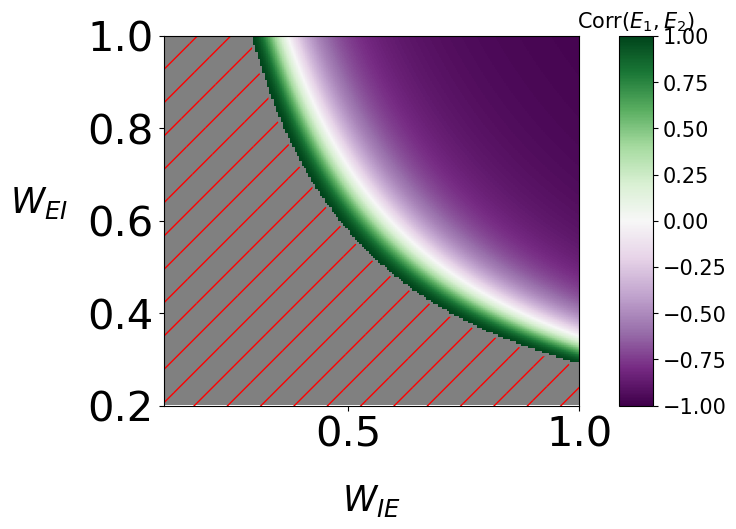

In [4]:
fig,ax = plt.subplots()
plt.rcParams.update({'hatch.color': 'red'})

# divnorm=colors.TwoSlopeNorm(vcenter=0)
# cmap=cm.get_cmap('PRGn')
cmap = cm.get_cmap("PRGn").copy()
cmap.set_bad(color='gray')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='8%', pad=.4)
im = ax.imshow(np.flip(Corrs_12, axis=0), cmap=cmap, vmin=-1, vmax= 1, extent=[0, 1, 0, 1])
cbar=fig.colorbar(im, cax=cax, orientation='vertical')

unstable_eigmask = np.ma.masked_less(Max_evrp,1) 
hatches = ax.contourf(Wei_vec, Wie_vec, unstable_eigmask, extent=[0, 1, 0, 1], hatches='//', alpha=0.)


ax.xaxis.set_tick_params(labelsize=30)
ax.yaxis.set_tick_params(labelsize=30)
ax.set_xlabel(r'$W_{IE}$', fontsize=25, labelpad=20)
ax.set_ylabel(r'$W_{EI}$', rotation=0, fontsize=25, labelpad=35)
cbar.ax.yaxis.set_tick_params(labelsize=15)

ax.set_xlim(0.1,1)
ax.set_ylim(0.2,1)
plt.title(r'Corr$(E_1,E_2)$', fontsize=15)

plt.show()

# Find the corrlation between E1 and E2 as a function of Wei=Wie (i.e., a slice in the above graph, but at a higher resolution)

In [5]:
Wei_vec = np.linspace(0, 2, K1D)

Corrs_12 = np.zeros((K1D,1))
Covs_12 = np.zeros((K1D,1))
Max_evrp = np.zeros((K1D,1))
eigs = np.zeros((K1D,3),dtype=np.complex_)
for i in range(K1D):
    Wei = Wei_vec[i]
    Wie = Wei_vec[i]
    W[0:2,2]=-Wei  # I->E
    W[2,0:2]=Wie # E->I
            
    Cov, Corr, Max_evrp[i], eigs[i,:] = corrTheory(W, DMatrix)
    Covs_12[i] = Cov[0,1]
    Corrs_12[i] = Corr[0,1]

# Find the boundaries of stability and pos/neg correlation    
xval_unstable = Wei_vec[np.where(Max_evrp>1)[0][-1]]
xval_negcorr = Wei_vec[np.where(Corrs_12<0)[0][0]]

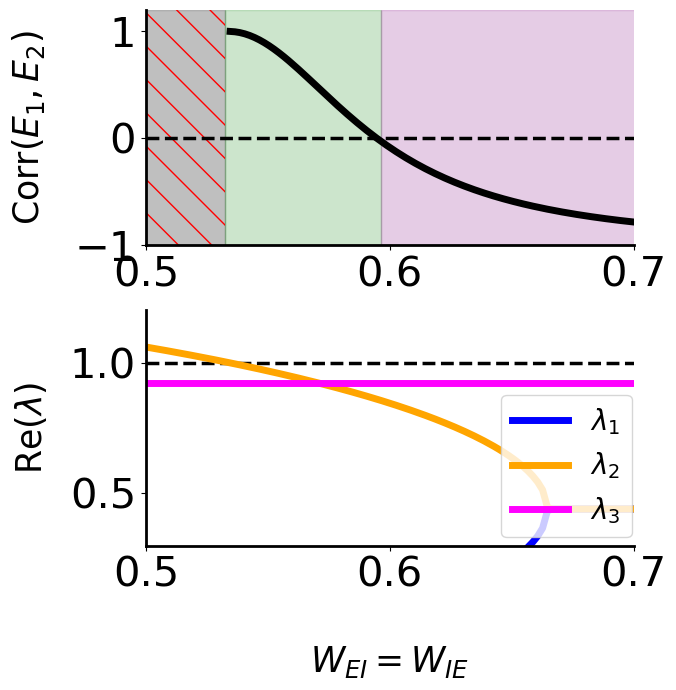

In [6]:
fig, ax = plt.subplots(2,1,figsize=(7,7))
plt.rcParams.update({'hatch.color': 'red'})

ax[0].plot(Wei_vec,Corrs_12,color="black", linestyle="-", linewidth=5)
ax[0].axhline(y=0, color="black", linestyle="--", linewidth=2.5)
ax[0].axvspan(0, xval_unstable, ymin=-1, ymax=1, alpha=0.5, color='gray')
ax[0].axvspan(0, xval_unstable, ymin=-1, ymax=1, hatch='\\', alpha=0)
ax[0].axvspan(xval_unstable, xval_negcorr, ymin=-1, ymax=1, alpha=.2, color='g')
ax[0].axvspan(xval_negcorr, 2, ymin=-1, ymax=1, alpha=.2, color='purple')
ax[0].set_ylim(-1,1.2)

ax[1].axhline(y=1, color="black", linestyle="--", linewidth=2.5)
ax[1].set_ylim(0.3,1.2)
ax[1].plot(Wei_vec, eigs[:,0].real, linewidth=5, label=r'$\lambda_1$', color='blue')
ax[1].plot(Wei_vec, eigs[:,1].real, linewidth=5, label=r'$\lambda_2$', color='orange')
ax[1].plot(Wei_vec, eigs[:,2].real, linewidth=5, label=r'$\lambda_3$', color='magenta')

for i in range(2):
    ax[i].set_xlim(0.5, 0.7)
    ax[i].spines.left.set_linewidth(2)
    ax[i].spines.bottom.set_linewidth(2)
    ax[i].spines.right.set_color('none')
    ax[i].spines.top.set_color('none')
    ax[i].xaxis.set_tick_params(labelsize=30)
    ax[i].yaxis.set_tick_params(labelsize=30)

ax[0].set_ylabel(r'Corr$(E_1,E_2)$', fontsize=25, labelpad=20)
ax[1].set_xlabel(r'$W_{EI}=W_{IE}$', rotation=0, fontsize=25, labelpad=35)
ax[1].set_ylabel(r'Re$(\lambda)$', fontsize=25, labelpad=15)
ax[1].legend(bbox_to_anchor=(.7,.7), loc="upper left", fontsize=20)

fig.tight_layout()
plt.show()

# Plot corr function and simulation for (Wei, Wie) in the postive correlation regime

In [7]:
# This is safely in the "green" region
Wie = 0.55
Wei = Wie
W[0:2,2]=-Wei  # I->E
W[2,0:2]=Wie # E->I

lagsTheory = np.arange(-4000,4000) # lags for theory 
corrMatrices = auto_corr(W, DMatrix, tau, lagsTheory)
eigs = np.linalg.eigvals(1/tau*(-np.eye(3)+W))

# Save the data for E1->E1, E1->E2, I->I
y11 = corrMatrices[:,0,0]
y12 = corrMatrices[:,0,1]
y33 = corrMatrices[:,2,2]

# Save eigenvalues
max_evrp = np.max(eigs.real)
egFixed = (-1-(-1+alpha)*Wee)/tau[0];
eigsSorted = np.sort(eigs.real)
if np.round(eigsSorted[1],5)==np.round(egFixed,5):
    eigI = eigsSorted[2]
else:
    eigI = eigsSorted[1]
max_evrp = np.max(eigs.real)

# Run the simulation for these parameters
print('Theory done, running numerical simulation (may take a few seconds)')
np.random.seed(221000) # Seed the random number generator to ensure consistency
Rates, timeVec = global_inh_model(r0, r_bar, 10_000, dt, W, tau, DMatrix)

Theory done, running numerical simulation (may take a few seconds)


### Plot the correlation functions

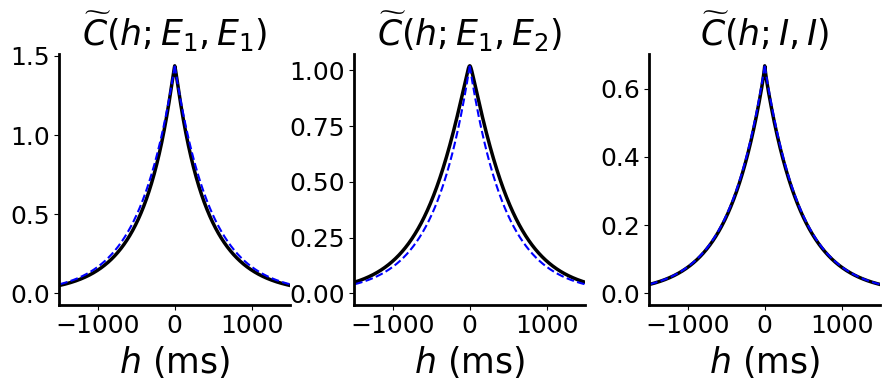

In [8]:
startPos = np.where(lagsTheory>=0)[0][0]

plt.rcParams["figure.figsize"]=9,4
fig, axs = plt.subplots(1,3)

axs[0].plot(lagsTheory, y11, color='black', linestyle='-', linewidth=2.5, label='Theory')
axs[0].plot(lagsTheory[startPos:],np.max(y11)*np.exp(max_evrp*lagsTheory[startPos:]),color='b',linestyle='--')
axs[0].plot(-lagsTheory[startPos:],np.max(y11)*np.exp(max_evrp*lagsTheory[startPos:]),color='b',linestyle='--')

axs[1].plot(lagsTheory, y12, color='black', linestyle='-', linewidth=2.5, label='Theory')
if y12[startPos]<0:
    A = np.min(y12)
else:
    A = np.max(y12)
axs[1].plot(lagsTheory[startPos:],A*np.exp(max_evrp*lagsTheory[startPos:]),color='b',linestyle='--')
axs[1].plot(-lagsTheory[startPos:],A*np.exp(max_evrp*lagsTheory[startPos:]),color='b',linestyle='--')

axs[2].plot(lagsTheory, y33, color='black', linestyle='-', linewidth=2.5, label='Theory')
axs[2].plot(lagsTheory[startPos:],np.max(y33)*np.exp(eigI*lagsTheory[startPos:]),color='b',linestyle='--')
axs[2].plot(-lagsTheory[startPos:],np.max(y33)*np.exp(eigI*lagsTheory[startPos:]),color='b',linestyle='--')

axs[0].set_title(r'$\widetilde{C}(h; E_1,E_1)$', fontsize=25)
axs[1].set_title(r'$\widetilde{C}(h; E_1,E_2)$', fontsize=25)
axs[2].set_title(r'$\widetilde{C}(h; I,I)$', fontsize=25)

axs[0].set_xlim(-1500,1500)
axs[1].set_xlim(-1500,1500)
if eigI>egFixed:
    axs[2].set_xlim(-1500,1500)
else:
    axs[2].set_xlim(-200,200)

for i in range(3):
    axs[i].spines.left.set_linewidth(2)
    axs[i].spines.bottom.set_linewidth(2)
    axs[i].spines.right.set_color('none')
    axs[i].spines.top.set_color('none')
    axs[i].set_xlabel(r'$h$ (ms)', fontsize=25)
    axs[i].xaxis.set_tick_params(labelsize=18)
    axs[i].yaxis.set_tick_params(labelsize=18)
    
fig.tight_layout()
plt.show()

### Plot the simulations

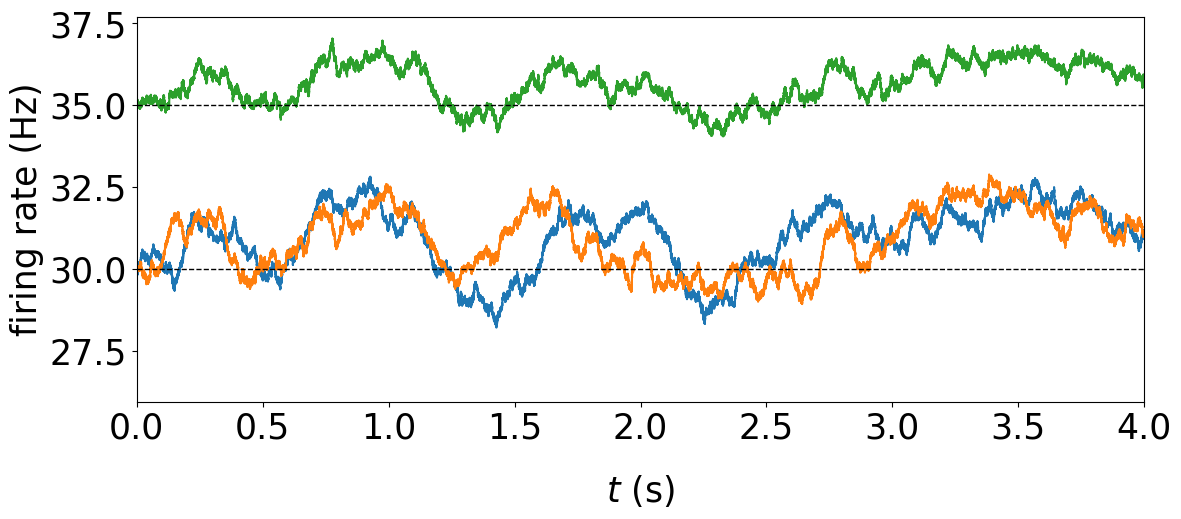

In [9]:
fig, ax = plt.subplots(figsize=(13,5))

ax.plot(timeVec,Rates[0,:])
ax.plot(timeVec,Rates[1,:])
ax.plot(timeVec,Rates[2,:])
ax.axhline(y=30, color="black", linestyle="--", linewidth=1)
ax.axhline(y=35, color="black", linestyle="--", linewidth=1)
ax.set_xlim(0,4)

ax.xaxis.set_tick_params(labelsize=25)
ax.yaxis.set_tick_params(labelsize=25)
ax.set_xlabel(r'$t$ (s)', fontsize=25, labelpad=20)
ax.set_ylabel('firing rate (Hz)', fontsize=25)

plt.show()

# Plot corr function and simulation for (Wei, Wie) in the negative correlation regime

In [10]:
lagsTheory = np.arange(-4000,4000) # lags for theory 

Wie = 0.8
Wei = Wie
W[0:2,2]=-Wei  # I->E
W[2,0:2]=Wie # E->I

lagsTheory = np.arange(-4000,4000) # lags for theory 
corrMatrices = auto_corr(W, DMatrix, tau, lagsTheory)
eigs = np.linalg.eigvals(1/tau*(-np.eye(3)+W))

# Save the data for E1->E1, E1->E2, I->I
y11 = corrMatrices[:,0,0]
y12 = corrMatrices[:,0,1]
y33 = corrMatrices[:,2,2]

# Save eigenvalues
max_evrp = np.max(eigs.real)
egFixed = (-1-(-1+alpha)*Wee)/tau[0];
eigsSorted = np.sort(eigs.real)
if np.round(eigsSorted[1],5)==np.round(egFixed,5):
    eigI = eigsSorted[2]
else:
    eigI = eigsSorted[1]
max_evrp = np.max(eigs.real)

# Run the simulation for these parameters
print('Theory done, running numerical simulation (may take a few seconds)')
np.random.seed(221000) # Seed the random number generator to ensure consistency
Rates, timeVec = global_inh_model(r0, r_bar, 10_000, dt, W, tau, DMatrix)

Theory done, running numerical simulation (may take a few seconds)


### Plot the correlation functions

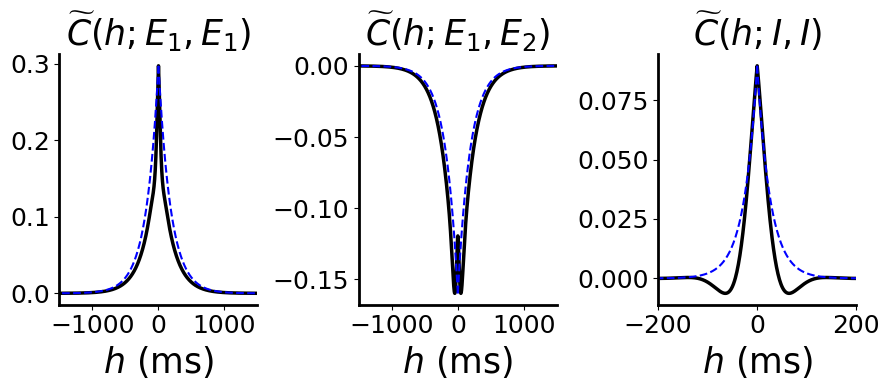

In [11]:
startPos = np.where(lagsTheory>=0)[0][0]

plt.rcParams["figure.figsize"]=9,4
fig, axs = plt.subplots(1,3)

axs[0].plot(lagsTheory, y11, color='black', linestyle='-', linewidth=2.5, label='Theory')
axs[0].plot(lagsTheory[startPos:],np.max(y11)*np.exp(max_evrp*lagsTheory[startPos:]),color='b',linestyle='--')
axs[0].plot(-lagsTheory[startPos:],np.max(y11)*np.exp(max_evrp*lagsTheory[startPos:]),color='b',linestyle='--')

axs[1].plot(lagsTheory, y12, color='black', linestyle='-', linewidth=2.5, label='Theory')
if y12[startPos]<0:
    A = np.min(y12)
else:
    A = np.max(y12)
axs[1].plot(lagsTheory[startPos:],A*np.exp(max_evrp*lagsTheory[startPos:]),color='b',linestyle='--')
axs[1].plot(-lagsTheory[startPos:],A*np.exp(max_evrp*lagsTheory[startPos:]),color='b',linestyle='--')

axs[2].plot(lagsTheory, y33, color='black', linestyle='-', linewidth=2.5, label='Theory')
axs[2].plot(lagsTheory[startPos:],np.max(y33)*np.exp(eigI*lagsTheory[startPos:]),color='b',linestyle='--')
axs[2].plot(-lagsTheory[startPos:],np.max(y33)*np.exp(eigI*lagsTheory[startPos:]),color='b',linestyle='--')

axs[0].set_title(r'$\widetilde{C}(h; E_1,E_1)$', fontsize=25)
axs[1].set_title(r'$\widetilde{C}(h; E_1,E_2)$', fontsize=25)
axs[2].set_title(r'$\widetilde{C}(h; I,I)$', fontsize=25)

axs[0].set_xlim(-1500,1500)
axs[1].set_xlim(-1500,1500)
if eigI>egFixed:
    axs[2].set_xlim(-1500,1500)
else:
    axs[2].set_xlim(-200,200)

for i in range(3):
    axs[i].spines.left.set_linewidth(2)
    axs[i].spines.bottom.set_linewidth(2)
    axs[i].spines.right.set_color('none')
    axs[i].spines.top.set_color('none')
    axs[i].set_xlabel(r'$h$ (ms)', fontsize=25)
    axs[i].xaxis.set_tick_params(labelsize=18)
    axs[i].yaxis.set_tick_params(labelsize=18)
    
fig.tight_layout()
plt.show()

### Plot the simulations

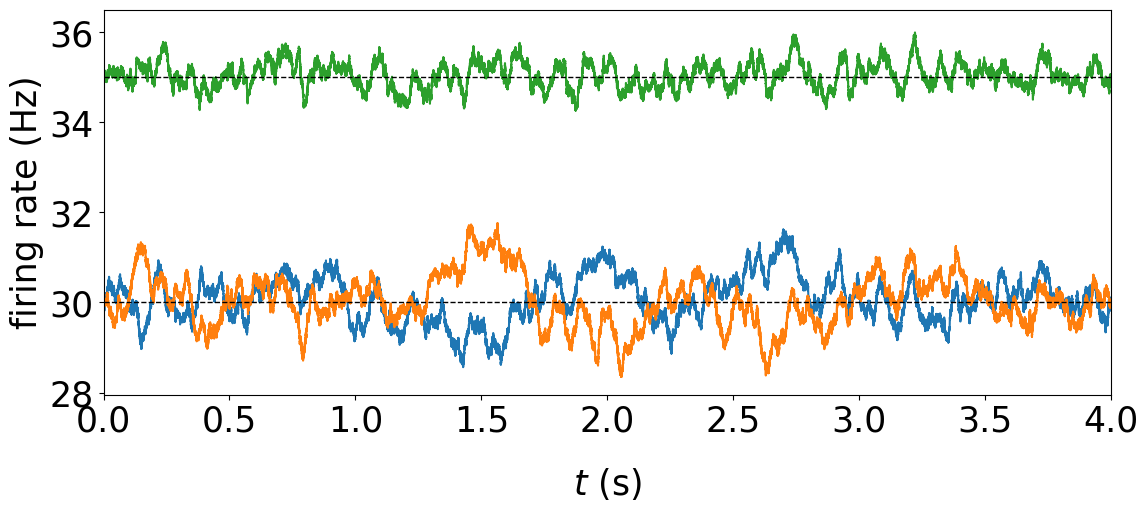

In [12]:
fig, ax = plt.subplots(figsize=(13,5))

ax.plot(timeVec,Rates[0,:])
ax.plot(timeVec,Rates[1,:])
ax.plot(timeVec,Rates[2,:])
ax.axhline(y=30, color="black", linestyle="--", linewidth=1)
ax.axhline(y=35, color="black", linestyle="--", linewidth=1)
ax.set_xlim(0,4)

ax.xaxis.set_tick_params(labelsize=25)
ax.yaxis.set_tick_params(labelsize=25)
ax.set_xlabel(r'$t$ (s)', fontsize=25, labelpad=20)
ax.set_ylabel('firing rate (Hz)', fontsize=25)

plt.show()

# Now lets look at the same parameters, except highlight correlation noise (c = 0.5)
The eigenvalues of M (i.e., I-W) don't depend on c. But as c->1, we essentially get a two dimensional system (exact correlation between E1 and E2). If E1 and E2 have the same initial condition, and c = 0, the winner-take-all solutional no longer occurs. 

In [13]:
# Strength and structure of noise
sigE=1; sigI=1; c=0.5

# 'Diffusion' matrix for the noise term
D_private = np.diag([np.sqrt(1-c)*sigE, np.sqrt(1-c)*sigE, sigI])
D_shared = np.array([np.sqrt(c)*sigE,np.sqrt(c)*sigE,0])
DMatrix = np.c_[D_private,D_shared]

Wee = 1.15; alpha = 0.2
Wii=0.5
Wei=0.8; Wie=0.8
W = np.block([[Wee, alpha*Wee, -Wei],
              [alpha*Wee, Wee, -Wei],
              [Wie, Wie, -Wii]])

In [14]:
#range of W_EI
Wei_vec = np.linspace(0, 1, K)
Wie_vec = np.linspace(0, 1, K) 

Corrs_12 = np.zeros((K,K))
Covs_12 = np.zeros((K,K))
Max_evrp = np.zeros((K,K))

for i in range(K):
        Wei = Wei_vec[i]
        for j in range(K):
            Wie = Wie_vec[j]
            
            W[0:2,2]=-Wei  # I->E
            W[2,0:2]=Wie # E->I
            
            Cov, Corr, Max_evrp[i,j],_ = corrTheory(W, DMatrix)
            Covs_12[i,j] = Cov[0,1]
            Corrs_12[i,j] = Corr[0,1]

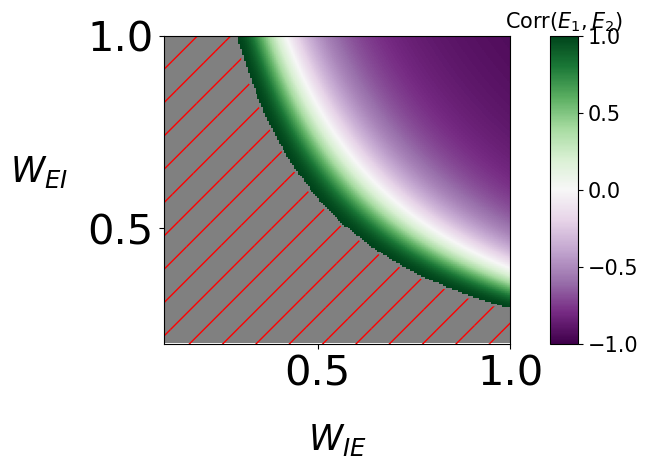

In [15]:
fig,ax = plt.subplots()
plt.rcParams.update({'hatch.color': 'red'})

# divnorm=colors.TwoSlopeNorm(vcenter=0)
# cmap=cm.get_cmap('PRGn')
cmap = cm.get_cmap("PRGn").copy()
cmap.set_bad(color='gray')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='8%', pad=.4)
im = ax.imshow(np.flip(Corrs_12, axis=0), cmap=cmap, vmin=-1, vmax= 1, extent=[0, 1, 0, 1])
cbar=fig.colorbar(im, cax=cax, orientation='vertical')

unstable_eigmask = np.ma.masked_less(Max_evrp,1) 
hatches = ax.contourf(Wei_vec, Wie_vec, unstable_eigmask, extent=[0, 1, 0, 1], hatches='//', alpha=0.)


ax.xaxis.set_tick_params(labelsize=30)
ax.yaxis.set_tick_params(labelsize=30)
ax.set_xlabel(r'$W_{IE}$', fontsize=25, labelpad=20)
ax.set_ylabel(r'$W_{EI}$', rotation=0, fontsize=25, labelpad=35)
cbar.ax.yaxis.set_tick_params(labelsize=15)

ax.set_xlim(0.1,1)
ax.set_ylim(0.2,1)
plt.title(r'Corr$(E_1,E_2)$', fontsize=15)

plt.show()

In [16]:
Wei_vec = np.linspace(0, 2, K1D)

Corrs_12 = np.zeros((K1D,1))
Covs_12 = np.zeros((K1D,1))
Max_evrp = np.zeros((K1D,1))
PR = np.zeros((K1D,1))
PR2 = np.zeros((K1D,1))
eigs = np.zeros((K1D,3),dtype=np.complex_)
for i in range(K1D):
    Wei = Wei_vec[i]
    Wie = Wei_vec[i]
    W[0:2,2]=-Wei  # I->E
    W[2,0:2]=Wie # E->I
            
    Cov, Corr, Max_evrp[i], eigs[i,:] = corrTheory(W, DMatrix)
    Covs_12[i] = Cov[0,1]
    Corrs_12[i] = Corr[0,1]
    
    subMatrix = Cov[0:2,0:2]
    CovSquared = Cov@Cov
    subMatrixSquared = CovSquared[0:2,0:2]
    if ~np.isnan(Cov[0,0]):
        PR[i] = sum(np.linalg.eigvals(Cov))**2/sum(np.linalg.eigvals(Cov@Cov))
        PR2[i] = sum(np.linalg.eigvals(subMatrix))**2/sum(np.linalg.eigvals(subMatrixSquared))

# Find the boundaries of stability and pos/neg correlation    
xval_unstable = Wei_vec[np.where(Max_evrp>1)[0][-1]]
xval_negcorr = Wei_vec[np.where(Corrs_12<0)[0][0]]

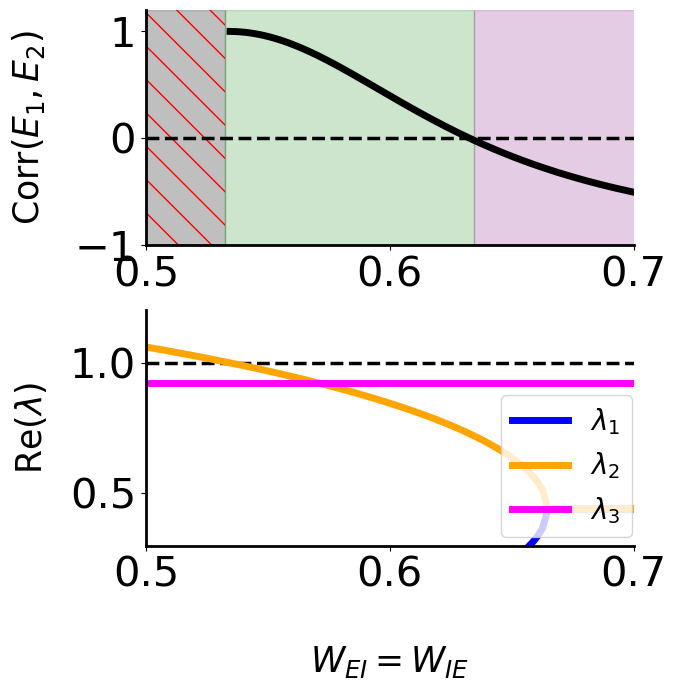

In [17]:
fig, ax = plt.subplots(2,1,figsize=(7,7))
plt.rcParams.update({'hatch.color': 'red'})

ax[0].plot(Wei_vec,Corrs_12,color="black", linestyle="-", linewidth=5)
ax[0].axhline(y=0, color="black", linestyle="--", linewidth=2.5)
ax[0].axvspan(0, xval_unstable, ymin=-1, ymax=1, alpha=0.5, color='gray')
ax[0].axvspan(0, xval_unstable, ymin=-1, ymax=1, hatch='\\', alpha=0)
ax[0].axvspan(xval_unstable, xval_negcorr, ymin=-1, ymax=1, alpha=.2, color='g')
ax[0].axvspan(xval_negcorr, 2, ymin=-1, ymax=1, alpha=.2, color='purple')
ax[0].set_ylim(-1,1.2)

ax[1].axhline(y=1, color="black", linestyle="--", linewidth=2.5)
ax[1].set_ylim(0.3,1.2)
ax[1].plot(Wei_vec, eigs[:,0].real, linewidth=5, label=r'$\lambda_1$', color='blue')
ax[1].plot(Wei_vec, eigs[:,1].real, linewidth=5, label=r'$\lambda_2$', color='orange')
ax[1].plot(Wei_vec, eigs[:,2].real, linewidth=5, label=r'$\lambda_3$', color='magenta')

for i in range(2):
    ax[i].set_xlim(0.5, 0.7)
    ax[i].spines.left.set_linewidth(2)
    ax[i].spines.bottom.set_linewidth(2)
    ax[i].spines.right.set_color('none')
    ax[i].spines.top.set_color('none')
    ax[i].xaxis.set_tick_params(labelsize=30)
    ax[i].yaxis.set_tick_params(labelsize=30)

ax[0].set_ylabel(r'Corr$(E_1,E_2)$', fontsize=25, labelpad=20)
ax[1].set_xlabel(r'$W_{EI}=W_{IE}$', rotation=0, fontsize=25, labelpad=35)
ax[1].set_ylabel(r'Re$(\lambda)$', fontsize=25, labelpad=15)
ax[1].legend(bbox_to_anchor=(.7,.7), loc="upper left", fontsize=20)

fig.tight_layout()
plt.show()

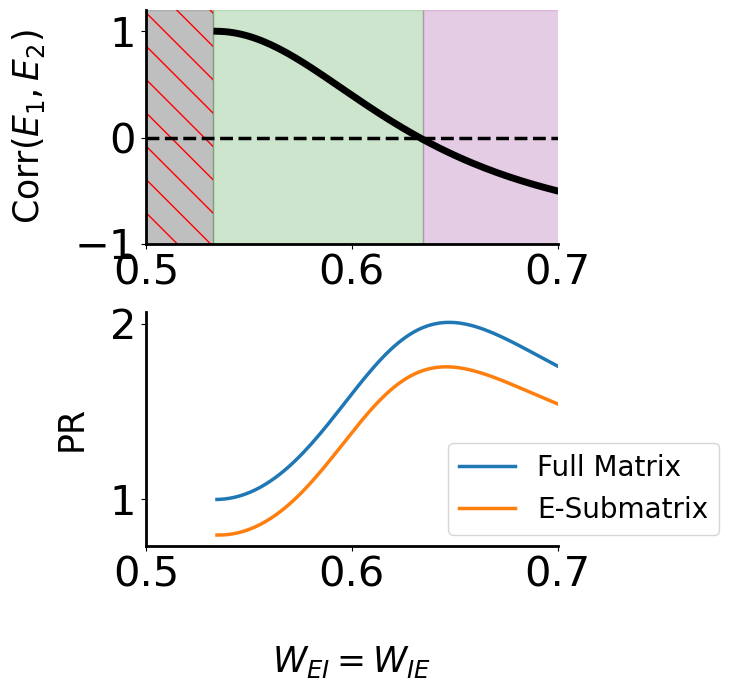

In [18]:
PR[0:np.where(Max_evrp>1)[0][-1]+1]=np.nan
PR2[0:np.where(Max_evrp>1)[0][-1]+1]=np.nan

fig, ax = plt.subplots(2,1,figsize=(7,7))
plt.rcParams.update({'hatch.color': 'red'})

ax[1].plot(Wei_vec,PR, linewidth=2.5,label=r'Full Matrix')
ax[1].plot(Wei_vec,PR2, linewidth=2.5,label=r'E-Submatrix')

ax[0].plot(Wei_vec,Corrs_12,color="black", linestyle="-", linewidth=5)
ax[0].axhline(y=0, color="black", linestyle="--", linewidth=2.5)
ax[0].axvspan(0, xval_unstable, ymin=-1, ymax=1, alpha=0.5, color='gray')
ax[0].axvspan(0, xval_unstable, ymin=-1, ymax=1, hatch='\\', alpha=0)
ax[0].axvspan(xval_unstable, xval_negcorr, ymin=-1, ymax=1, alpha=.2, color='g')
ax[0].axvspan(xval_negcorr, 2, ymin=-1, ymax=1, alpha=.2, color='purple')
ax[0].set_ylim(-1,1.2)

for i in range(2):
    ax[i].set_xlim(0.5, 0.7)
    ax[i].spines.left.set_linewidth(2)
    ax[i].spines.bottom.set_linewidth(2)
    ax[i].spines.right.set_color('none')
    ax[i].spines.top.set_color('none')
    ax[i].xaxis.set_tick_params(labelsize=30)
    ax[i].yaxis.set_tick_params(labelsize=30)

ax[0].set_ylabel(r'Corr$(E_1,E_2)$', fontsize=25, labelpad=20)
ax[1].set_xlabel(r'$W_{EI}=W_{IE}$', rotation=0, fontsize=25, labelpad=35)
ax[1].set_ylabel(r'PR', fontsize=25, labelpad=15)
ax[1].legend(bbox_to_anchor=(.7,.5), loc="upper left", fontsize=20)

fig.tight_layout()
plt.show()

In [19]:
lagsTheory = np.arange(-4000,4000) # lags for theory 

Wie = 0.6
Wei = Wie
W[0:2,2]=-Wei  # I->E
W[2,0:2]=Wie # E->I

lagsTheory = np.arange(-4000,4000) # lags for theory 
corrMatrices = auto_corr(W, DMatrix, tau, lagsTheory)
eigs = np.linalg.eigvals(1/tau*(-np.eye(3)+W))

# Save the data for E1->E1, E1->E2, I->I
y11 = [x[0,0] for x in corrMatrices]
y12 = [x[0,1] for x in corrMatrices]
y33 = [x[2,2] for x in corrMatrices]

# Save eigenvalues
max_evrp = np.max(eigs.real)
egFixed = (-1-(-1+alpha)*Wee)/tau[0];
eigsSorted = np.sort(eigs.real)
if np.round(eigsSorted[1],5)==np.round(egFixed,5):
    eigI = eigsSorted[2]
else:
    eigI = eigsSorted[1]
max_evrp = np.max(eigs.real)

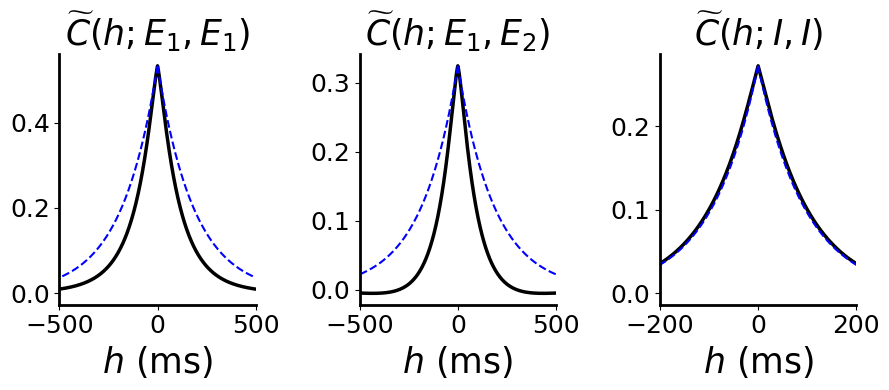

In [20]:
startPos = np.where(lagsTheory>=0)[0][0]

plt.rcParams["figure.figsize"]=9,4
fig, axs = plt.subplots(1,3)

axs[0].plot(lagsTheory, y11, color='black', linestyle='-', linewidth=2.5, label='Theory')
axs[0].plot(lagsTheory[startPos:],np.max(y11)*np.exp(max_evrp*lagsTheory[startPos:]),color='b',linestyle='--')
axs[0].plot(-lagsTheory[startPos:],np.max(y11)*np.exp(max_evrp*lagsTheory[startPos:]),color='b',linestyle='--')

axs[1].plot(lagsTheory, y12, color='black', linestyle='-', linewidth=2.5, label='Theory')
A = np.max(y12)
axs[1].plot(lagsTheory[startPos:],A*np.exp(max_evrp*lagsTheory[startPos:]),color='b',linestyle='--')
axs[1].plot(-lagsTheory[startPos:],A*np.exp(max_evrp*lagsTheory[startPos:]),color='b',linestyle='--')

axs[2].plot(lagsTheory, y33, color='black', linestyle='-', linewidth=2.5, label='Theory')
axs[2].plot(lagsTheory[startPos:],np.max(y33)*np.exp(eigI*lagsTheory[startPos:]),color='b',linestyle='--')
axs[2].plot(-lagsTheory[startPos:],np.max(y33)*np.exp(eigI*lagsTheory[startPos:]),color='b',linestyle='--')

axs[0].set_title(r'$\widetilde{C}(h; E_1,E_1)$', fontsize=25)
axs[1].set_title(r'$\widetilde{C}(h; E_1,E_2)$', fontsize=25)
axs[2].set_title(r'$\widetilde{C}(h; I,I)$', fontsize=25)

axs[0].set_xlim(-500,500)
axs[1].set_xlim(-500,500)
if eigI>egFixed:
    axs[2].set_xlim(-200,200)
else:
    axs[2].set_xlim(-200,200)

for i in range(3):
    axs[i].spines.left.set_linewidth(2)
    axs[i].spines.bottom.set_linewidth(2)
    axs[i].spines.right.set_color('none')
    axs[i].spines.top.set_color('none')
    axs[i].set_xlabel(r'$h$ (ms)', fontsize=25)
    axs[i].xaxis.set_tick_params(labelsize=18)
    axs[i].yaxis.set_tick_params(labelsize=18)
    
fig.tight_layout()
plt.show()

In [21]:
# Run the simulation for these parameters
print('Running numerical simulation (may take a few seconds)')
np.random.seed(221000) # Seed the random number generator to ensure consistency
Rates, timeVec = global_inh_model(r0, r_bar, 10_000, dt, W, tau, DMatrix)

Running numerical simulation (may take a few seconds)


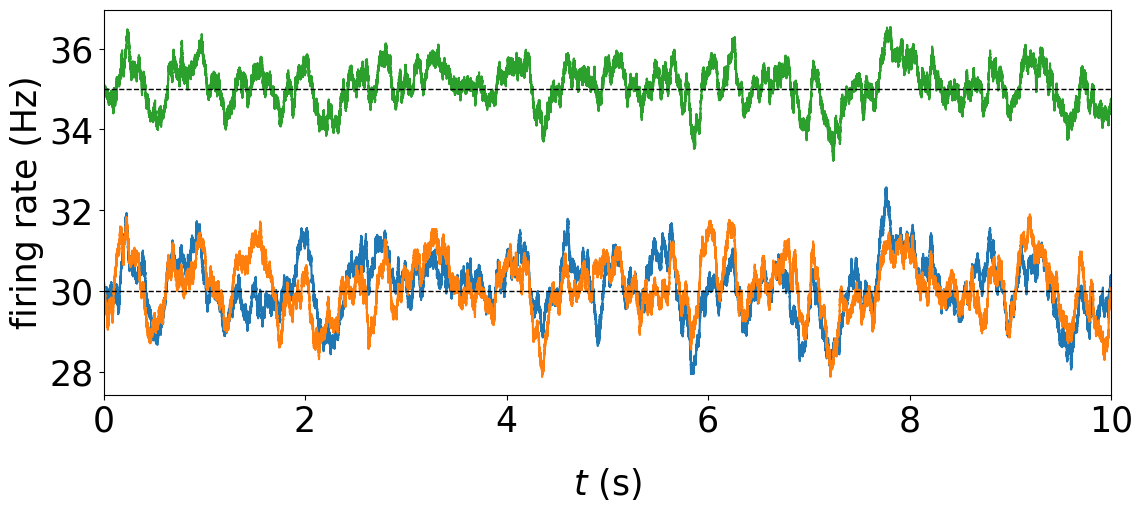

In [22]:
fig, ax = plt.subplots(figsize=(13,5))

ax.plot(timeVec,Rates[0,:])
ax.plot(timeVec,Rates[1,:])
ax.plot(timeVec,Rates[2,:])
ax.axhline(y=30, color="black", linestyle="--", linewidth=1)
ax.axhline(y=35, color="black", linestyle="--", linewidth=1)
ax.set_xlim(0,10)

ax.xaxis.set_tick_params(labelsize=25)
ax.yaxis.set_tick_params(labelsize=25)
ax.set_xlabel(r'$t$ (s)', fontsize=25, labelpad=20)
ax.set_ylabel('firing rate (Hz)', fontsize=25)

plt.show()